In [52]:
import numpy as np
import regression as reg
from scipy import io
from auxiliary_merge import m_DateList
from matplotlib import pyplot as plt


def empirical_cdf(data, probtar):
    # data: vector of data
    data2 = data[~np.isnan(data)]
    if len(data2) > 0:
        ds = np.sort(data2)
        probreal = np.arange(len(data2)) / (len(data2) + 1)
        ecdf_out = np.interp(probtar, probreal, ds)
    else:
        ecdf_out = np.nan * np.zeros(len(probtar))
    return ecdf_out


def cdf_correction(cdf_ref, value_ref, cdf_raw, value_raw, value_tar):
    prob_tar = np.interp(value_tar, value_raw, cdf_raw)
    value_out = np.interp(prob_tar, cdf_ref, value_ref)
    return value_out

### Local Mac settings
# input files/paths
gmet_stnfile = '/Users/localuser/Research/EMDNA/basicinfo/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/Research/EMDNA/stndata_whole.npz'
file_mask = './DEM/NA_DEM_010deg_trim.mat'
near_file_GMET = '/Users/localuser/Research/EMDNA/regression/weight_nearstn.npz' # near station of stations/grids
file_readownstn = ['/Users/localuser/Research/EMDNA/downscale/ERA5_downto_stn_nearest.npz', # downscaled to stn points
                   '/Users/localuser/Research/EMDNA/downscale/MERRA2_downto_stn_nearest.npz',
                   '/Users/localuser/Research/EMDNA/downscale/JRA55_downto_stn_nearest.npz']

# output files/paths (can also be used as inputs once generated)
near_path = '/Users/localuser/Research/EMDNA/correction'  # path to save near station for each grid/cell
path_ecdf = '/Users/localuser/Research/EMDNA/merge/ECDF'
file_pop = '/Users/localuser/Research/EMDNA/merge/reanalysis_pop'
### Local Mac settings


# ### Plato settings
# gmet_stnfile = '/datastore/GLOBALWATER/CommonData/EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stndatafile = '/datastore/GLOBALWATER/CommonData/EMDNA/stndata_whole.npz'
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
# near_file_GMET = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout/weight.npz'
# file_readownstn = ['/datastore/GLOBALWATER/CommonData/EMDNA/ERA5_day_ds/ERA5_downto_stn_GWR.npz', # downscaled to stn points
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds/MERRA2_downto_stn_GWR.npz',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/JRA55_day_ds/JRA55_downto_stn_GWR.npz']
# near_path = '/home/gut428/ReanalysisCorrMerge'  # path to save near station for each grid/cell
# path_ecdf = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/ECDF'
# file_pop = '/home/gut428/ReanalysisCorrMerge/reanalysis_pop'
# ### Plato settings

near_stnfile = near_path + '/near_stn_prcp.npz'
near_gridfile = near_path + '/near_grid_prcp.npz'



In [2]:
########################################################################################################################

# basic processing
print('start basic processing')

lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
# mask
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels

# meshed lat/lon of the target region
reanum = len(file_readownstn)
nrows, ncols = np.shape(mask)
lontarm, lattarm = np.meshgrid(lontar, lattar)
lontarm[np.isnan(mask)] = np.nan
lattarm[np.isnan(mask)] = np.nan

# date list
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# load observations for all stations
datatemp = np.load(gmet_stndatafile)
stndata = datatemp['prcp_stn']
stnlle = datatemp['stn_lle']
nstn, ntimes = np.shape(stndata)
del datatemp

# load near station information
datatemp = np.load(near_file_GMET)
near_loc_stn = datatemp['near_stn_prcpLoc']
near_weight_stn = datatemp['near_stn_prcpWeight']
near_dist_stn = datatemp['near_stn_prcpDist']
# near_loc_grid = datatemp['near_grid_prcpLoc']
# near_weight_grid = datatemp['near_grid_prcpWeight']
# near_dist_grid = datatemp['near_grid_prcpDist']
# near_loc = np.flipud(near_loc_grid)
# near_weight = np.flipud(near_weight_grid)
# near_dist = np.flipud(near_dist_grid)

# probability bins for QM
binprob = 500
ecdf_prob = np.arange(0, 1 + 1 / binprob, 1 / binprob)

########################################################################################################################

# load downscaled reanalysis at station points
print('load downscaled reanalysis data at station points')
readata_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
for rr in range(reanum):
    dr = np.load(file_readownstn[rr])
    temp = dr['prcp_readown']
    readata_stn[rr, :, :] = temp
    del dr, temp
readata_stn[readata_stn < 0] = 0

start basic processing
load downscaled reanalysis data at station points


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


In [131]:
rea_pop1 = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
for rr in range(1):
    for gg in range(nstn):
        if not np.mod(gg,20)==0:
            continue
        if np.mod(gg,500)==0:
            print(gg)
        if np.isnan(stndata[gg, 0]):
            continue
        nearloc = near_loc_stn[gg, :]
        neardist = near_dist_stn[gg, :]
        nearweight = near_weight_stn[gg, :]
        neardist = neardist[nearloc > -1]
        nearweight = nearweight[nearloc > -1]
        nearloc = nearloc[nearloc > -1]

        nstn_prcp = len(nearloc)
        w_pcp_red = np.zeros([nstn_prcp, nstn_prcp])
        for i in range(nstn_prcp):
            w_pcp_red[i, i] = nearweight[i]  # eye matrix: stn weight in one-one lien

        x_red = np.ones([nstn_prcp, 2])

        for tt in range(365):
            prea_tar = readata_stn[rr, gg, tt]
            if stndata[gg, tt]>0:
                pstn_tar = 1
            else:
                pstn_tar = 0
            prea_near = readata_stn[rr, nearloc, tt]
            pstn_near = stndata[nearloc, tt]
            pstn_near[pstn_near > 0] = 1

            # logistic regression
            if np.all(pstn_near == 1):
                rea_pop1[rr, gg, tt] = 1
            elif np.all(pstn_near == 0) or np.all(prea_near == 0):
                rea_pop1[rr, gg, tt] = 0
            else:
                x_red[:, 1] = prea_near
                tx_red = np.transpose(x_red)
                twx_red = np.matmul(tx_red, w_pcp_red)
                b = reg.logistic_regression(x_red, twx_red, pstn_near)
                zb = - np.dot(np.array([1,prea_tar]), b)
                rea_pop1[rr, gg, tt] = 1 / (1 + np.exp(zb))

0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000


In [179]:
rea_pop1_temp = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
for rr in range(reanum):
    for gg in range(1):
        if not np.mod(gg,20)==0:
            continue
        if np.mod(gg,500)==0:
            print(gg)
        if np.isnan(stndata[gg, 0]):
            continue
        nearloc = near_loc_stn[gg, :]
        neardist = near_dist_stn[gg, :]
        nearweight = near_weight_stn[gg, :]
        neardist = neardist[nearloc > -1]
        nearweight = nearweight[nearloc > -1]
        nearloc = nearloc[nearloc > -1]

        nstn_prcp = len(nearloc)
        w_pcp_red = np.zeros([nstn_prcp, nstn_prcp])
        for i in range(nstn_prcp):
            w_pcp_red[i, i] = nearweight[i]  # eye matrix: stn weight in one-one lien

        x_red = np.ones([nstn_prcp, 2])

        for tt in range(366,ntimes):
            prea_tar = readata_stn[rr, gg, tt]
            if stndata[gg, tt]>0:
                pstn_tar = 1
            else:
                pstn_tar = 0
            prea_near = readata_stn[rr, nearloc, tt]
            pstn_near = stndata[nearloc, tt]
            pstn_near[pstn_near > 0] = 1

            # logistic regression
            if np.all(pstn_near == 1):
                rea_pop1[rr, gg, tt] = 1
            elif np.all(pstn_near == 0) or np.all(prea_near == 0):
                rea_pop1[rr, gg, tt] = 0
            else:
                x_red[:, 1] = prea_near
                tx_red = np.transpose(x_red)
                twx_red = np.matmul(tx_red, w_pcp_red)
                b = reg.logistic_regression(x_red, twx_red, pstn_near)
                zb = - np.dot(np.array([1,prea_tar]), b)
                rea_pop1_temp[rr, gg, tt] = 1 / (1 + np.exp(zb))

0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp


0
0


In [188]:
rea_pop11 = np.zeros([nstn, ntimes], dtype=np.float32)
for gg in range(1):
    if np.isnan(stndata[gg, 0]):
        continue
    nearloc = near_loc_stn[gg, :]
    neardist = near_dist_stn[gg, :]
    nearweight = near_weight_stn[gg, :]
    neardist = neardist[nearloc > -1]
    nearweight = nearweight[nearloc > -1]
    nearloc = nearloc[nearloc > -1]

    nstn_prcp = len(nearloc)
    w_pcp_red = np.zeros([nstn_prcp, nstn_prcp])
    for i in range(nstn_prcp):
        w_pcp_red[i, i] = nearweight[i]  # eye matrix: stn weight in one-one lien

    x_red = np.ones([nstn_prcp, 4])

    for tt in range(366,ntimes):
        prea_tar = readata_stn[:, gg, tt]
        prea_tar2 = np.ones(reanum+1)
        prea_tar2[1:]=prea_tar
        if stndata[gg, tt] > 0:
            pstn_tar = 1
        else:
            pstn_tar = 0
        prea_near = readata_stn[:, nearloc, tt]
        pstn_near = stndata[nearloc, tt]
        pstn_near[pstn_near > 0] = 1

        # logistic regression
        if np.all(pstn_near == 1):
            rea_pop1[rr, gg, tt] = 1
        elif np.all(pstn_near == 0) or np.all(prea_near ==0):
            rea_pop1[rr, gg, tt] = 0
        else:
            x_red[:, 1:4] = prea_near.T
            tx_red = np.transpose(x_red)
            twx_red = np.matmul(tx_red, w_pcp_red)
            b = reg.logistic_regression(x_red, twx_red, pstn_near)
            if np.all(b==0):
                rea_pop11[gg, tt] = 0
            else:
                zb = - np.dot(prea_tar2, b)
                rea_pop11[gg, tt] = 1 / (1 + np.exp(zb))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp


In [194]:
obs=stndata[0,:].copy()
obs[obs>0]=1
for i in range(3):
    print(cal_csi(obs, rea_pop1_temp[i,0,:],0.5))
print(cal_csi(obs, rea_pop11[0,:],0.5))
print(cal_csi(obs, np.nanmean(rea_pop1_temp[:,0,:],axis=0),0.5))

0.7696027633851468
0.7453862485709619
0.7366666666666667
0.5597687239478284
0.7620947630922693


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [193]:
rea_pop11[gg, tt]

0.0

In [238]:
date_list, date_number = m_DateList(1979, 2018, 'ByYear')
rea_pop2 = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
for rr in range(reanum):
    for gg in range(0,10):
        if np.mod(gg,500)==0:
            print(gg)
        if np.isnan(stndata[gg, 0]):
            continue
        nearloc = near_loc_stn[gg, :]
        neardist = near_dist_stn[gg, :]
        nearweight = near_weight_stn[gg, :]
        neardist = neardist[nearloc > -1]
        nearweight = nearweight[nearloc > -1]
        nearweight = nearweight / np.sum(nearweight)
        nearloc = nearloc[nearloc > -1]
        nstn_prcp = len(nearloc)

        for mm in range(12):
            indm = date_number['mm'] == (mm+1)
            prea_tar = readata_stn[rr, gg, indm]
            pstn_near = stndata[nearloc,:][:, indm]
            ecdf_reatar = empirical_cdf(prea_tar, ecdf_prob)
            popmm_near = np.zeros([nstn_prcp, np.sum(indm)])
            popmm = np.zeros(np.sum(indm))
            for i in range(nstn_prcp):
                # a simple Qunatile mapping by sorting
                ecdf_neari = empirical_cdf(pstn_near[i,:], ecdf_prob)
                pqm = cdf_correction(ecdf_prob, ecdf_neari, ecdf_prob, ecdf_reatar, pstn_near[i,:])
                pqm[pqm > 0] = 1
                popmm_near[i, :] = pqm
                popmm = popmm + pqm * nearweight[i]
            rea_pop2[rr, gg, indm] = popmm

0
0
0


In [197]:
rea_pop1[:,:,365:]=np.nan
rea_pop2[:,:,365:]=np.nan
csi=np.nan * np.zeros([nstn,2])
bs=np.nan * np.zeros([nstn,2])
for i in range(0,27000,20):
    obs=stndata[i,:].copy()
    obs[obs>0]=1
    csi[i,0]=cal_csi(obs, rea_pop1[0,i,:],0.5)
    csi[i,1]=cal_csi(obs, rea_pop2[0,i,:],0.5)
    bs[i,0]=np.nanmean((obs - rea_pop1[0,i,:])**2)
    bs[i,1]=np.nanmean((obs - rea_pop2[0,i,:])**2)
csi = csi[~np.isnan(csi[:,0]),:]
bs = bs[~np.isnan(bs[:,0]),:]
print(np.nanmean(csi,axis=0))
print(np.nanmean(bs,axis=0))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launc

[0.60599306 0.52258967]
[0.10463801 0.11367713]


In [248]:
np.shape(rea_pop2[:,1,date_number['mm']==3])

(3, 1240)

In [243]:
from bma_merge import bma
weight, sigma, sigma_s = bma(rea.T, obs)
weight

array([0.35316675, 0.329166  , 0.31766725])

Text(0.5, 1.0, 'Brier score')

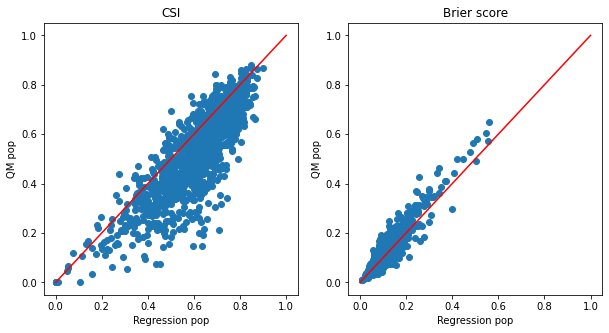

In [198]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.scatter(csi[:,0],csi[:,1])
plt.plot([0,1],[0,1],'r')
plt.xlabel('Regression pop')
plt.ylabel('QM pop')
plt.title('CSI')

plt.subplot(1,2,2)
plt.scatter(bs[:,0],bs[:,1])
plt.plot([0,1],[0,1],'r')
plt.xlabel('Regression pop')
plt.ylabel('QM pop')
plt.title('Brier score')

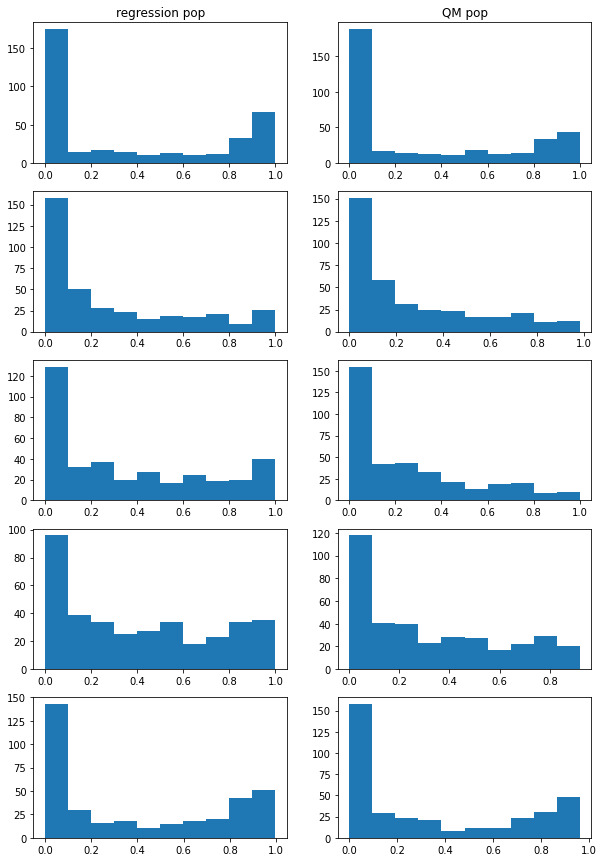

In [150]:
plt.figure(figsize=[10,15])
ii=np.arange(0,2500,500)
for i in range(5):
    plt.subplot(5,2,(i+1)*2-1)
    zz = rea_pop1[0,ii[i],:]
    plt.hist(zz[:])
    if i==0:
        plt.title('regression pop')
    plt.subplot(5,2,(i+1)*2)
    zz = rea_pop2[0,ii[i],:]
    plt.hist(zz[:])
    if i==0:
        plt.title('QM pop')

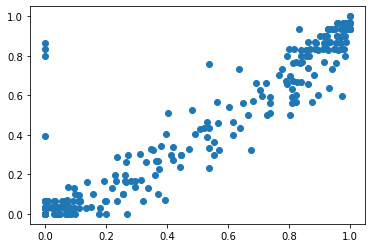

In [151]:
plt.scatter(rea_pop1[0,0,:], rea_pop2[0,0,:])

In [199]:
near_file_GMET = '/Users/localuser/Research/EMDNA/regression/weight_nearstn.npz'
near_loc_grid = datatemp['near_grid_prcpLoc']
near_weight_grid = datatemp['near_grid_prcpWeight']
near_dist_grid = datatemp['near_grid_prcpDist']

In [234]:
nearloc_unique = np.zeros([nrows * ncols, np.shape(near_loc_grid)[2]])
flag = 0
for r in range(nrows):
    for c in range(ncols):
        nearloc_unique[flag, :] = near_loc_grid[r, c, :]
        flag = flag + 1
nearloc_unique = np.unique(nearloc_unique, axis=0)
nearloc_uniflag = np.zeros([nrows, ncols])
for r in range(59,nrows):
    print(r)
    for c in range(ncols):
        if np.isnan(mask[r, c]):
            continue
        nearloc_uniflag[r, c] = np.where(near_loc_grid[r, c, :] in nearloc_unique)[0][0]

KeyboardInterrupt: 